In [1]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
conn = wrds.Connection(wrds_username='suyogmahale')


Loading library list...
Done


In [4]:
def download_compustat_data(conn, start_year=2020, end_year=2025):
    """
    Pull key annual accounting items from Compustat Fundamentals Annual (comp.funda)
    and apply standard Fama-French style filters:
      indfmt='INDL', datafmt='STD', consol='C', popsrc='D'
    """

    cols = [
        "gvkey",      # firm identifier
        "datadate",   # fiscal period end date
        "fyear",      # fiscal year
        "indfmt", "datafmt", "consol", "popsrc",
        "revt",       # revenue
        "cogs",       # cost of goods sold
        "at",         # total assets
        "seq",        # stockholders' equity
        "ceq",        # common equity
        "pstk",       # preferred stock (carrying value)
        "pstkr",      # preferred stock redemption value
        "pstkl",      # preferred stock liquidating value
        "txditc",     # deferred taxes & investment tax credit
        "txdb",       # deferred taxes
        "itcb",       # investment tax credit
        "sich"        # historical SIC if sic is missing
    ]

    df = conn.get_table(library="comp", table="funda", columns=cols)

    # convert datadate to datetime
    df["datadate"] = pd.to_datetime(df["datadate"], errors="coerce")

    # apply Fama-French standard filters
    df = df[
        (df["fyear"] >= start_year) &
        (df["fyear"] <= end_year) &
        (df["indfmt"] == "INDL") &
        (df["datafmt"] == "STD") &
        (df["consol"] == "C") &
        (df["popsrc"] == "D")
    ].copy()

    # fill SIC fallback
    if "sic" not in df.columns:
        df["sic"] = np.nan
    if df["sic"].isna().all() and "sich" in df.columns:
        df["sic"] = df["sich"]

    return df

compustat_raw = download_compustat_data(
    conn,
    start_year=2020,   # adjust as needed
    end_year=2025      # <-- make sure this covers years you care about
)

In [5]:
def download_ccm_link(conn):
    """
    Pull CRSP–Compustat link table. This maps Compustat gvkey to CRSP permno.
    Keep only primary links (linkprim in 'P','C') and standard link types ('LU','LC').
    """

    cols = [
        "gvkey",
        "lpermno",      # CRSP PERMNO
        "linktype",
        "linkprim",
        "linkdt",       # link start
        "linkenddt"     # link end
    ]

    ccm = conn.get_table(library="crsp", table="ccmxpf_linktable", columns=cols)

    # normalize columns
    ccm.columns = [c.lower() for c in ccm.columns]

    # ensure expected cols exist
    for col in ["gvkey", "lpermno", "linktype", "linkprim", "linkdt", "linkenddt"]:
        if col not in ccm.columns:
            ccm[col] = np.nan

    # parse dates
    ccm["linkdt"] = pd.to_datetime(ccm["linkdt"], errors="coerce")
    ccm["linkenddt"] = pd.to_datetime(ccm["linkenddt"], errors="coerce")
    ccm["linkenddt"] = ccm["linkenddt"].fillna(pd.Timestamp("2099-12-31"))

    # filter to primary, standard links
    ccm = ccm[
        (ccm["linktype"].isin(["LU", "LC"])) &
        (ccm["linkprim"].isin(["P", "C"]))
    ].copy()

    # rename lpermno → permno for clarity
    ccm = ccm.rename(columns={"lpermno": "permno"})

    # keep clean set
    ccm = ccm[["gvkey", "permno", "linkdt", "linkenddt"]].dropna(subset=["permno"]).reset_index(drop=True)

    # make sure permno is int-ish
    ccm["permno"] = ccm["permno"].astype(int)

    return ccm

ccm_link = download_ccm_link(conn)


In [6]:
def download_crsp_data(conn, start_date='2020-01-01', end_date='2024-12-31'):
    """
    Pull CRSP *daily* stock data.

    We use:
      - crsp.dsf      : daily security file
      - crsp.dsenames : header/name history including ticker, exchcd, shrcd

    We will:
      - filter to major exchanges (exchcd in 1,2,3)
      - filter to common shares (shrcd in 10,11)
      - clean price (abs(prc))
      - compute daily market equity = prc * shrout * 1000
    """

    # 1. Daily security file (dsf)
    dsf_cols = [
        "permno",
        "date",
        "ret",      # daily return
        "prc",      # price (can be signed)
        "vol",      # volume
        "shrout"    # shares outstanding (thousands)
    ]

    dsf = conn.get_table(library="crsp", table="dsf", columns=dsf_cols)

    dsf["date"] = pd.to_datetime(dsf["date"], errors="coerce")

    dsf = dsf[
        (dsf["date"] >= pd.to_datetime(start_date)) &
        (dsf["date"] <= pd.to_datetime(end_date))
    ].copy()

    # 2. Daily security names (dsenames)
    # Columns differ across WRDS installs but usually:
    # permno, namedt, nameenddt (or nameendt/nameend), exchcd, shrcd, ticker
    dsen_cols = [
        "permno",
        "namedt",
        "nameendt",
        "exchcd",
        "shrcd",
        "ticker"
    ]

    dsenames = conn.get_table(library="crsp", table="dsenames", columns=dsen_cols)

    # normalize start/end validity window
    dsenames["namedt"] = pd.to_datetime(dsenames["namedt"], errors="coerce")

    # handle end date column variations
    if "nameenddt" in dsenames.columns and dsenames["nameenddt"].notna().any():
        dsenames["nameenddt"] = pd.to_datetime(dsenames["nameenddt"], errors="coerce")
    else:
        if "nameendt" in dsenames.columns and dsenames["nameendt"].notna().any():
            dsenames["nameenddt"] = pd.to_datetime(dsenames["nameendt"], errors="coerce")
        elif "nameend" in dsenames.columns and dsenames["nameend"].notna().any():
            dsenames["nameenddt"] = pd.to_datetime(dsenames["nameend"], errors="coerce")
        else:
            dsenames["nameenddt"] = pd.Timestamp("2099-12-31")

    dsenames["nameenddt"] = dsenames["nameenddt"].fillna(pd.Timestamp("2099-12-31"))

    # keep only what we actually need downstream
    dsenames = dsenames[["permno", "namedt", "nameenddt", "exchcd", "shrcd", "ticker"]].copy()

    # 3. merge daily observations with security headers
    crsp_daily = dsf.merge(dsenames, on="permno", how="left")

    # keep only rows where that header definition is active for that day
    crsp_daily = crsp_daily[
        (crsp_daily["date"] >= crsp_daily["namedt"]) &
        (crsp_daily["date"] <= crsp_daily["nameenddt"])
    ].copy()

    # if overlapping header windows, keep most recent namedt
    crsp_daily = (
        crsp_daily
        .sort_values(["permno", "date", "namedt"])
        .drop_duplicates(subset=["permno", "date"], keep="last")
        .reset_index(drop=True)
    )

    # 4. Filter to common shares on main exchanges, like we did monthly
    crsp_daily = crsp_daily[
        (crsp_daily["exchcd"].isin([1, 2, 3])) &
        (crsp_daily["shrcd"].isin([10, 11]))
    ].copy()

    # 5. Clean numeric fields
    crsp_daily["prc"] = crsp_daily["prc"].astype(float).abs()
    crsp_daily["shrout"] = crsp_daily["shrout"].astype(float)

    # Market equity (ME) in dollars
    crsp_daily["me"] = crsp_daily["prc"] * (crsp_daily["shrout"] * 1000.0)

    return crsp_daily



crsp_raw = download_crsp_data(
    conn,
    start_date='2020-01-01',   # adjust
    end_date='2024-12-31'      # adjust
)

In [7]:
def calculate_gross_profitability(compustat_df):
    """
    Gross Profitability (Novy-Marx style):
      GP/A = (revt - cogs) / at

    We'll:
    - ensure revt, cogs, at exist
    - compute gp_at
    - keep only rows where gp_at is defined and assets > 0
    """

    df = compustat_df.copy()

    for col in ["revt", "cogs", "at"]:
        if col not in df.columns:
            df[col] = np.nan

    df["gross_profits"] = df["revt"] - df["cogs"]
    df["gp_at"] = df["gross_profits"] / df["at"]

    # filter out nonsense: require positive assets and defined gp_at
    valid_mask = (
        df["gp_at"].notna() &
        df["at"].notna() &
        (df["at"] > 0)
    )
    df = df[valid_mask].copy()

    return df


In [8]:
def build_signal_panel(compustat_df, crsp_df, ccm_df):
    """
    Merge Compustat fundamentals (by gvkey, datadate) with CRSP monthly data
    (by permno, date) using CCM link (gvkey <-> permno active window).

    Returns panel with:
      gvkey, permno, ticker, date, prc, me,
      gp_at, revt, cogs, at,
      datadate (accounting snapshot matched to that market date)
    """

    # 1. Compute gross profitability on accounting side
    acct = calculate_gross_profitability(compustat_df).copy()

    # force types / columns
    acct["datadate"] = pd.to_datetime(acct["datadate"], errors="coerce")
    acct = acct.dropna(subset=["gvkey", "datadate"])
    acct["gvkey"] = acct["gvkey"].astype(str)

    acct = acct[["gvkey", "datadate", "revt", "cogs", "at", "gp_at"]]

    # 2. Clean CCM link (gvkey <-> permno with link dates)
    link = ccm_df.copy()
    link["linkdt"] = pd.to_datetime(link["linkdt"], errors="coerce")
    link["linkenddt"] = pd.to_datetime(link["linkenddt"], errors="coerce")
    link["linkenddt"] = link["linkenddt"].fillna(pd.Timestamp("2099-12-31"))

    link = link.dropna(subset=["gvkey", "permno", "linkdt"])
    link["gvkey"] = link["gvkey"].astype(str)
    link["permno"] = link["permno"].astype(int)

    # 3. Attach gvkey + link window to CRSP
    crsp_l = crsp_df.copy()
    crsp_l["date"] = pd.to_datetime(crsp_l["date"], errors="coerce")
    crsp_l = crsp_l.dropna(subset=["permno", "date"])
    crsp_l["permno"] = crsp_l["permno"].astype(int)

    crsp_l = crsp_l.merge(
        link[["gvkey", "permno", "linkdt", "linkenddt"]],
        on="permno",
        how="left"
    )

    # drop rows that didn't map to a gvkey (no accounting link)
    crsp_l = crsp_l.dropna(subset=["gvkey", "linkdt"])
    crsp_l["gvkey"] = crsp_l["gvkey"].astype(str)

    # keep only rows where the link is active for that date
    crsp_l = crsp_l[
        (crsp_l["date"] >= crsp_l["linkdt"]) &
        (crsp_l["date"] <= crsp_l["linkenddt"])
    ].copy()

    # dedupe overlapping link periods
    crsp_l = (
        crsp_l
        .sort_values(["gvkey", "permno", "date", "linkdt"])
        .drop_duplicates(subset=["gvkey", "permno", "date"], keep="last")
        .reset_index(drop=True)
    )

    # 4. Prepare frames for merge_asof
    # IMPORTANT:
    # merge_asof requires the left frame sorted by left_on ("date")
    # and the right frame sorted by right_on ("datadate").
    # "by" columns (gvkey) can exist in both but don't change that requirement.

    crsp_for_merge = crsp_l.dropna(subset=["date"]).copy()
    acct_for_merge = acct.dropna(subset=["datadate"]).copy()

    # sort JUST by the merge key col (pandas requirement)
    crsp_for_merge = crsp_for_merge.sort_values("date").reset_index(drop=True)
    acct_for_merge = acct_for_merge.sort_values("datadate").reset_index(drop=True)

    # 5. merge_asof: match each (gvkey, date) with the latest datadate <= date
    panel = pd.merge_asof(
        crsp_for_merge,
        acct_for_merge,
        left_on="date",
        right_on="datadate",
        by="gvkey",
        direction="backward",
        allow_exact_matches=True
    )

    # 6. Final tidy / select columns that actually exist
    keep_cols = [
        "gvkey",
        "permno",
        "ticker",
        "date",
        "prc",
        "me",
        "gp_at",
        "revt",
        "cogs",
        "at",
        "datadate"
    ]
    keep_cols = [c for c in keep_cols if c in panel.columns]

    panel = panel[keep_cols].reset_index(drop=True)

    return panel

panel = build_signal_panel(
    compustat_df=compustat_raw,
    crsp_df=crsp_raw,
    ccm_df=ccm_link
)


In [9]:
def get_ticker_timeseries(panel_df, ticker, start_year=2020, end_year=2025):
    """
    Filter the merged panel for a single ticker across a year range.
    Returns a time series with:
      date, price, gp_at, revt, cogs, at
    """

    ts = panel_df[
        (panel_df["ticker"].str.upper() == ticker.upper()) &
        (panel_df["date"].dt.year >= start_year) &
        (panel_df["date"].dt.year <= end_year)
    ].copy()

    ts = ts.sort_values("date")

    # Keep the relevant columns in a nice order
    ts = ts[[
        "date",
        "ticker",
        "prc",
        "gp_at",
        "revt",
        "cogs",
        "at",
        "datadate",
        "me"
    ]]

    return ts

In [ ]:
def plot_price_and_gp(ts, ticker):
    """
    Plot price and gross profitability gp_at on two y-axes over time
    for a single ticker's time series dataframe (as returned by get_ticker_timeseries).
    """

    if ts.empty:
        print(f"No data to plot for {ticker}.")
        return

    fig, ax1 = plt.subplots(figsize=(10,6))

    # Price on left y-axis
    ax1.plot(ts["date"], ts["prc"], color = 'green', linewidth=2)
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price", fontsize=12)

    # GP/A on right y-axis
    ax2 = ax1.twinx()
    ax2.plot(ts["date"], ts["gp_at"], color = 'blue', linewidth=2)
    ax2.set_ylabel("Gross Profitability (GP/A)", fontsize=12)

    plt.title(f"{ticker}: Price vs Gross Profitability", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    fig.tight_layout()
    plt.show()

In [11]:
ticker_of_interest = "AAPL"   # change this to whatever ticker you want
ts = get_ticker_timeseries(
    panel_df=panel,
    ticker=ticker_of_interest,
    start_year=2020,
    end_year=2025
)

print(ts.head(20))

            date ticker        prc  gp_at  revt  cogs    at datadate  \
3215  2020-01-02   AAPL  300.35001   <NA>  <NA>  <NA>  <NA>      NaT   
3910  2020-01-03   AAPL  297.42999   <NA>  <NA>  <NA>  <NA>      NaT   
8123  2020-01-06   AAPL  299.79999   <NA>  <NA>  <NA>  <NA>      NaT   
13152 2020-01-07   AAPL  298.39001   <NA>  <NA>  <NA>  <NA>      NaT   
14801 2020-01-08   AAPL  303.19000   <NA>  <NA>  <NA>  <NA>      NaT   
20265 2020-01-09   AAPL  309.63000   <NA>  <NA>  <NA>  <NA>      NaT   
23961 2020-01-10   AAPL  310.32999   <NA>  <NA>  <NA>  <NA>      NaT   
26268 2020-01-13   AAPL  316.95999   <NA>  <NA>  <NA>  <NA>      NaT   
29897 2020-01-14   AAPL  312.67999   <NA>  <NA>  <NA>  <NA>      NaT   
32522 2020-01-15   AAPL  311.34000   <NA>  <NA>  <NA>  <NA>      NaT   
36462 2020-01-16   AAPL  315.23999   <NA>  <NA>  <NA>  <NA>      NaT   
39943 2020-01-17   AAPL  318.73001   <NA>  <NA>  <NA>  <NA>      NaT   
42522 2020-01-21   AAPL  316.57001   <NA>  <NA>  <NA>  <NA>     

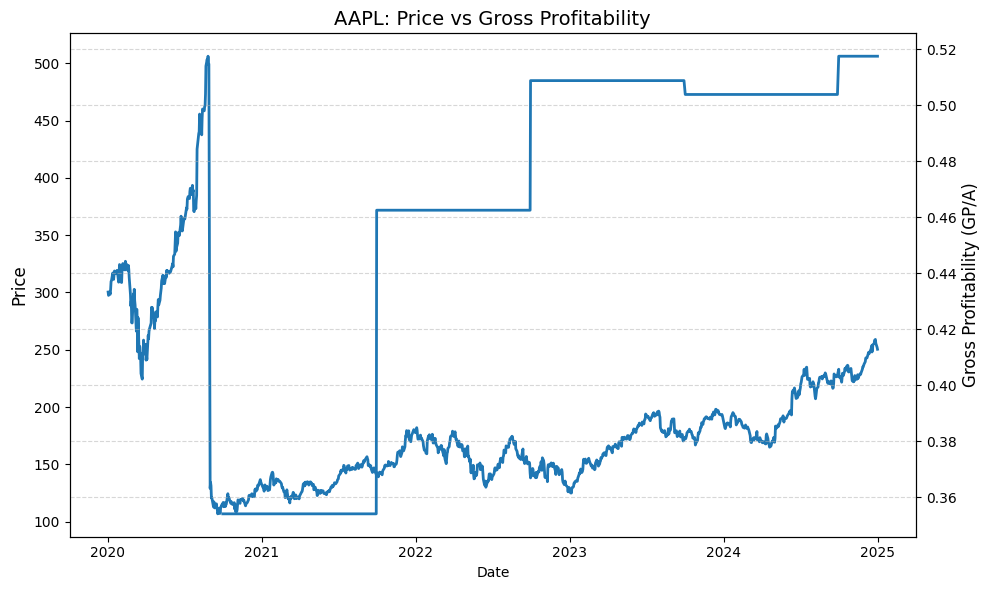

In [12]:
plot_price_and_gp(ts, ticker_of_interest)